## Visualizing movies spanning across different time periods & languages in the form of clusters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data=pd.read_csv(r'../Desktop/DATASETS_ALL/Movies.csv',encoding='utf-8',low_memory=False)
data.head()

Unnamed: 0     id  adult                        title original_language  \
0           0    278  False     The Shawshank Redemption                en   
1           1  19404  False  Dilwale Dulhania Le Jayenge                hi   
2           2    238  False                The Godfather                en   
3           3    424  False             Schindler's List                en   
4           4    240  False        The Godfather Part II                en   

                                            overview  \
0  Framed in the 1940s for the double murder of h...   
1  Raj is a rich, carefree, happy-go-lucky second...   
2  Spanning the years 1945 to 1955, a chronicle o...   
3  The true story of how businessman Oskar Schind...   
4  In the continuing saga of the Corleone crime f...   

                       title.1  popularity release_date  vote_average  \
0     The Shawshank Redemption      86.715   1994-09-23           8.7   
1  Dilwale Dulhania Le Jayenge      54.110   1995-10-19           8.7   
2                The Godfather     121.661   1972-03-14           8.7   
3             Schindler's List      55.646   1993-12-15           8.6   
4        The Godfather Part II      62.479   1974-12-20           8.6   

   vote_count  
0       21988  
1        3769  
2       16371  
3       13038  
4        9868

In [3]:
datacopy=data.copy()
datacopy2=data.copy()
#creating a checkpoint

In [4]:
saved_overview_text=[i for i in data['overview']]

len(saved_overview_text)

9980

In [5]:
saved_overview_text[9000]

'Verena is a nurse who arrives at an old mansion in Italy to help a young boy who has fallen silent since the sudden passing of his mother.'

## For the first viz, I would be using 

In [6]:
!pip install langcodes

In [7]:
!pip install language_data

In [6]:
lang_codes=data['original_language'].unique()

from langcodes import *


def map_code2lang(x):
    for i in lang_codes:
        if i==x:
            language=Language.make(language=i).display_name()
        
    return language.lower()

data['original_language']=data['original_language'].apply(lambda x: map_code2lang(x))

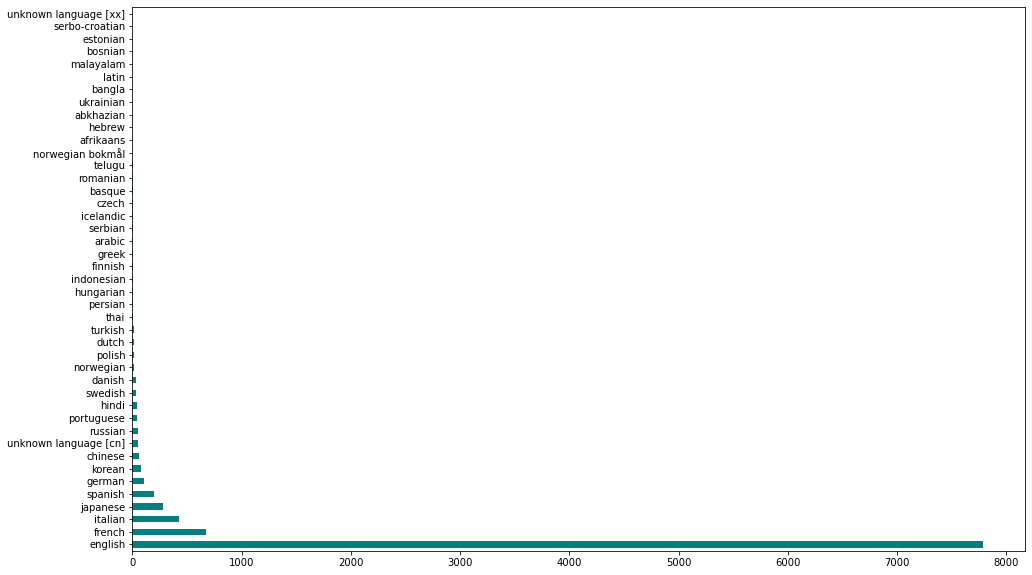

In [7]:
data['original_language'].value_counts().plot(kind='barh',figsize=(16,10),color='teal');


In [8]:
data['original_language'].value_counts().T

english                  7784
french                    675
italian                   427
japanese                  280
spanish                   196
german                    103
korean                     77
chinese                    57
unknown language [cn]      56
russian                    48
portuguese                 43
hindi                      42
swedish                    36
danish                     31
norwegian                  18
polish                     16
dutch                      13
turkish                    11
thai                       10
persian                     7
hungarian                   6
indonesian                  6
finnish                     4
greek                       4
arabic                      3
serbian                     3
icelandic                   3
czech                       3
basque                      2
romanian                    2
telugu                      2
norwegian bokmål            1
afrikaans                   1
hebrew    

#### So, the first problem here entials the huge class imbalance that lies in the dataset. To tackle that, I am basing our judgements on the 'top 50' (in terms of 'vote_score') from the highest crossing languages in the dataset (like english, french,hindi, italian etc) which have round >100 movies each. Although common middle-eastern languages like persian and arabic each have only 7 and 3 (respectively) representatives in the dataset, I am clubbing them together to have some significant reprentation from the middle-east film world. Others with <30 representations in the dataset, will unfortunately have to be skipped to remove bias.

### Categorizing the release years of movies into different timeframe periods

In [9]:
data['release_date']=pd.to_datetime(data['release_date'],format='%Y-%m-%d')

In [10]:
stored_year_labels=[]
for i in pd.DatetimeIndex(data['release_date']).year:
    stored_year_labels.append(i)
print(f"Timeframe start: {min(stored_year_labels)}")
print(f"Timeframe end: {max(stored_year_labels)}")

print(f"Timeframe length: {max(stored_year_labels)-min(stored_year_labels)}")

Timeframe start: 1902
Timeframe end: 2022
Timeframe length: 120


For the study, divided the timeframe of various movies into 4 separate timeframes. Took refernce from this blog here which discusses the major timelines of world cinema:
https://timelineofcinema.com/

In [11]:
timeframe_categories=[]


for j in stored_year_labels:
        if 1902<=j<1945:
            timeframe_categories.append('1902-1945')
        elif 1945<=j<1985:
            timeframe_categories.append('1945-1985')
        elif 1985<=j<2000:
            timeframe_categories.append('1985-2000')
        elif 2000<=j<=2010:
            timeframe_categories.append('2000-2010')
        elif 2010<j<=2022:
            timeframe_categories.append('2010-2022')
        
            
data['timeframes']=timeframe_categories

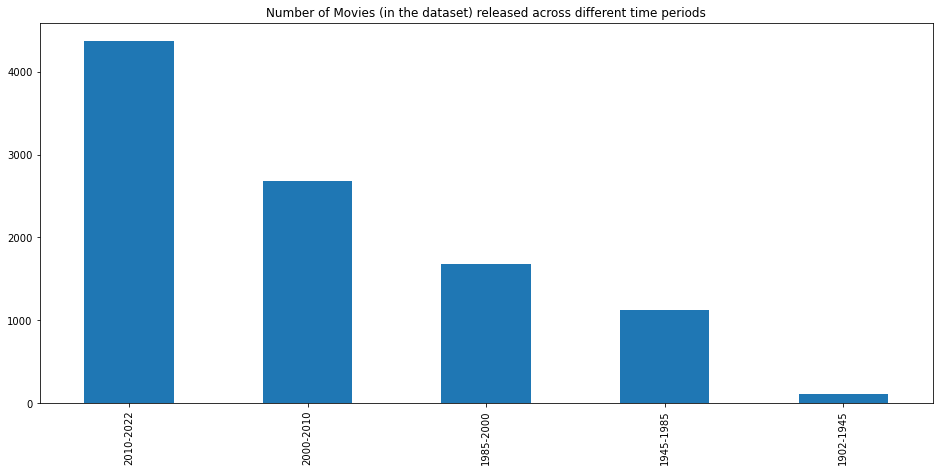

In [12]:
data['timeframes'].value_counts().plot(kind='bar',figsize=(16,7),title='Number of Movies (in the dataset) released across different time periods');

In [13]:
data['timeframes']

0       1985-2000
1       1985-2000
2       1945-1985
3       1985-2000
4       1945-1985
          ...    
9975    2000-2010
9976    2010-2022
9977    2000-2010
9978    2010-2022
9979    2000-2010
Name: timeframes, Length: 9980, dtype: object

In [14]:
data['overview'].isna().sum()

11

In [15]:
data.dropna(inplace=True,axis=0,subset=['overview','timeframes'])

In [16]:
data['overview'].isna().sum()

0

In [17]:
text_overview=[[i] for i in data['overview']]
#text_overview

In [18]:
for news in text_overview[0]:
    print(news)

Framed in the 1940s for the double murder of his wife and her lover, upstanding banker Andy Dufresne begins a new life at the Shawshank prison, where he puts his accounting skills to work for an amoral warden. During his long stretch in prison, Dufresne comes to be admired by the other inmates -- including an older prisoner named Red -- for his integrity and unquenchable sense of hope.


In [19]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
words_remove=['The','the','but','But','When','when','after']
for i in words_remove:
    stop.add(i)
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for i in range(len(text_overview)):
        for news in text_overview[i]:
            words=[w for w in word_tokenize(news) if (w not in stop)]
        
            words=[lem.lemmatize(w) for w in words if len(w)>2]
        
            corpus.append(words)
    return corpus

corpus=preprocess_news(text_overview)
data['corpus']=corpus
data['corpus2']=corpus

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [101]:
#corpus

In [102]:
data['corpus2']

0       [Framed, 1940s, double, murder, wife, lover, u...
1       [Raj, rich, carefree, happy-go-lucky, second, ...
2       [Spanning, year, 1945, 1955, chronicle, fictio...
3       [true, story, businessman, Oskar, Schindler, s...
4       [continuing, saga, Corleone, crime, family, yo...
                              ...                        
9975    [genetically, created, Anaconda, cut, half, re...
9976    [Earth, conquered, robot, another, galaxy, hum...
9977    [Cancer-terminal, tycoon, Peter, Murdoch, secr...
9978    [day, Gerri, Dandridge, sexy, professor, night...
9979    [Three, chimp, sent, space, explore, possibili...
Name: corpus2, Length: 9969, dtype: object

In [103]:
#data['corpus2'][9979]

In [20]:

def strip_corpus(x):
    import re
    x=re.sub('[^a-zA-Z0-9 ]','',str(x))
    return x

data['corpus']=data['corpus'].apply(lambda x: strip_corpus(x))

In [21]:
data['corpus'][9900]

'single mom two boy help take care grandmother mystical power'

In [24]:
!pip install pyLDAvis==3.2.1

In [35]:
!python -m pip install -U gensim

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.23
    Uninstalling Cython-0.29.23:
      Successfully uninstalled Cython-0.29.23


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
evalml 0.53.1 requires networkx<2.6,>=2.5, but you have networkx 2.6 which is incompatible.


In [106]:
def build_wordcloud(text):
    from wordcloud import WordCloud
    plt.figure(figsize=(16,7))
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

def build_ldaviz(x,i):
    import gensim
    import pyLDAvis
    #import pyLDAvis.gensim_models
    import pyLDAvis.gensim as gensimvis
    pyLDAvis.enable_notebook()

    dic=gensim.corpora.Dictionary(data[data['original_language']==x]['corpus2'][:i])
    
    bow_corpus = [dic.doc2bow(doc) for doc in data[data['original_language']==x]['corpus2'][:i]]
    lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, 
                                   num_topics=4, 
                                   id2word = dic,
                                   random_state=42,
                                   chunksize=1000,
                                   passes = 50,
                                   iterations=100)
    
    vis =gensimvis.prepare(lda_model, bow_corpus, dic)
    pyLDAvis.save_html(vis, 'lda.html')
    return vis
    

In [24]:
data.sort_values(ascending=False,by='popularity',ignore_index=True,inplace=True)
#data

In [25]:
len(data[data['original_language']=='hindi']['corpus'][:50])

42

In [32]:
str_hi=' '
for i in data[data['original_language']=='hindi']['corpus'][:50]:
    str_hi+=i+' '

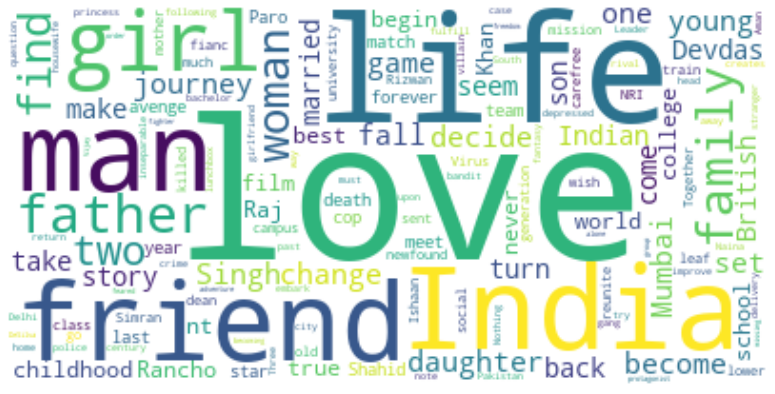

In [33]:
build_wordcloud(str_hi)

In [32]:
build_ldaviz('hindi',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.121552 -0.003355       1        1  31.607663
1     -0.046781 -0.093569       2        1  26.753620
2     -0.040938  0.097158       3        1  25.130577
0     -0.033833 -0.000235       4        1  16.508140, topic_info=        Term      Freq     Total Category  logprob  loglift
499     game  3.000000  3.000000  Default  30.0000  30.0000
639   Shahid  2.000000  2.000000  Default  29.0000  29.0000
85      Khan  2.000000  2.000000  Default  28.0000  28.0000
115  journey  3.000000  3.000000  Default  27.0000  27.0000
513      son  2.000000  2.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
134    young  0.619105  3.526239   Topic4  -5.5749   0.0616
582   feared  0.619044  1.722691   Topic4  -5.5750   0.7778
56     begin  0.619008  2.263586   Topic4  -5.5750   0.5047
145     else  0.618968  1.671382   Topic4  -5.5751   0.8080
155     much  0.618968  1.671382   Topic4  -5.5751   0.8080

[229 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.814541       ...
80        2  0.346860     After
80        3  0.346860     After
80        4  0.346860     After
547       3  0.850096  Although
...     ...       ...       ...
120       3  0.414595     world
134       1  0.283588     young
134       2  0.283588     young
134       3  0.283588     young
134       4  0.283588     young

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [33]:
data_hi=data[data['original_language']=='hindi']
data_hi.reset_index(drop=True,inplace=True)
#data_hi

In [34]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

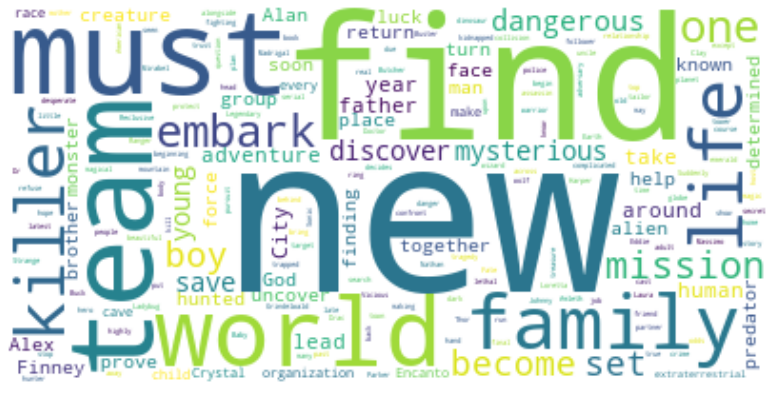

In [35]:
str_en=' '
en_top50=data[data['original_language']=='english'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in en_top50['corpus']:
    str_en+=i+' '


%matplotlib inline

build_wordcloud(str_en)


In [36]:
build_ldaviz('english',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.062809  0.083671       1        1  25.998050
3     -0.072059 -0.089261       2        1  25.826798
1      0.089561 -0.032311       3        1  25.775321
2      0.045307  0.037900       4        1  22.399832, topic_info=            Term      Freq     Total Category  logprob  loglift
46        killer  4.000000  4.000000  Default  30.0000  30.0000
543         cave  2.000000  2.000000  Default  29.0000  29.0000
186    dangerous  3.000000  3.000000  Default  28.0000  28.0000
107         find  5.000000  5.000000  Default  27.0000  27.0000
342         Alan  2.000000  2.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
541       behind  0.690778  1.718306   Topic4  -5.9326   0.5848
377    collision  0.690773  1.712653   Topic4  -5.9326   0.5881
380       course  0.690773  1.712653   Topic4  -5.9326   0.5881
210       Parker  0.690726  1.712655   Topic4  -5.9327   0.5881
232  complicated  0.690678  1.712657   Topic4  -5.9327   0.5880

[211 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
135       3  0.861702  13-year-old
21        1  0.189793        After
21        2  0.379586        After
21        3  0.379586        After
342       2  0.853847         Alan
...     ...       ...          ...
80        3  0.346843         year
80        4  0.346843         year
280       2  0.291089        young
280       3  0.291089        young
280       4  0.291089        young

[240 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

data_en=data[data['original_language']=='english'][:50]
data_en.reset_index(drop=True,inplace=True)


fig = px.scatter(data_en, x=data_en['tsne_coords_x'], y=data_en['tsne_coords_y'],size=data_en['popularity'],
                 color=data_en['timeframes'],hover_name=data_en['title'],log_x=False, size_max=60)
fig.show()

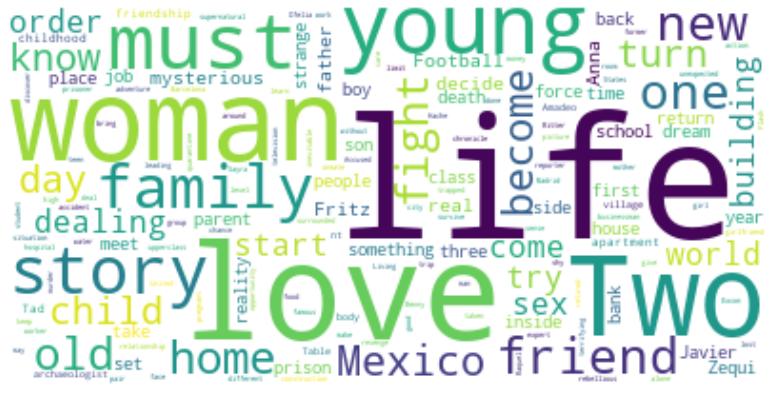

In [37]:
str_es=' '
es_top50=data[data['original_language']=='spanish'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in es_top50['corpus']:
    str_es+=i+' '


build_wordcloud(str_es)

In [38]:
build_ldaviz('spanish',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.117319  0.001348       1        1  38.385790
1     -0.044031  0.077290       2        1  21.713692
3     -0.039647 -0.099829       3        1  20.081029
2     -0.033640  0.021192       4        1  19.819490, topic_info=           Term      Freq     Total Category  logprob  loglift
21        child  2.000000  2.000000  Default  30.0000  30.0000
132        love  6.000000  6.000000  Default  29.0000  29.0000
63         time  2.000000  2.000000  Default  28.0000  28.0000
192        bank  2.000000  2.000000  Default  27.0000  27.0000
308         sex  2.000000  2.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
457        lost  0.659569  1.779810   Topic4  -5.8035   0.6258
161       force  0.659565  2.329706   Topic4  -5.8035   0.3566
186  girlfriend  0.659514  1.779804   Topic4  -5.8035   0.6257
288      inmate  0.659512  1.779822   Topic4  -5.8035   0.6257
513   Barcelona  0.659498  1.631486   Topic4  -5.8036   0.7127

[235 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
440       1  1.034799     ...
189       1  0.561129   After
189       2  0.280564   After
189       3  0.280564   After
473       1  0.765410  Amadeo
...     ...       ...     ...
71        3  0.428419    year
142       1  0.377358   young
142       2  0.188679   young
142       3  0.188679   young
142       4  0.188679   young

[301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

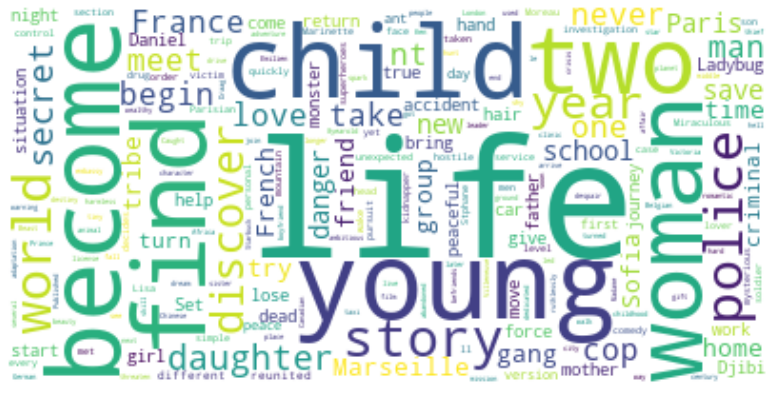

In [39]:
str_fr=' '
fr_top50=data[data['original_language']=='french'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in fr_top50['corpus']:
    str_fr+=i+' '


build_wordcloud(str_fr)

In [40]:
build_ldaviz('french',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.073144  0.049702       1        1  31.008682
2     -0.066457 -0.037826       2        1  24.246846
3      0.058192 -0.089948       3        1  22.977343
0      0.081409  0.078072       4        1  21.767129, topic_info=         Term      Freq     Total Category  logprob  loglift
235  daughter  3.000000  3.000000  Default  30.0000  30.0000
224     world  3.000000  3.000000  Default  29.0000  29.0000
504     Sofia  2.000000  2.000000  Default  28.0000  28.0000
28        two  4.000000  4.000000  Default  27.0000  27.0000
669   version  2.000000  2.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
295       one  1.235968  3.367275   Topic4  -5.4593   0.5225
113     woman  1.234967  4.647734   Topic4  -5.4601   0.1994
68       life  1.234054  7.445452   Topic4  -5.4609  -0.2725
200      home  0.687528  2.885511   Topic4  -6.0458   0.0904
582    Africa  0.687401  1.753138   Topic4  -6.0460   0.5885

[208 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
274       1  0.558627    ...
274       2  0.279313    ...
274       4  0.279313    ...
791       4  0.887881    100
553       1  0.830457   1910
...     ...       ...    ...
302       2  0.434696   year
302       3  0.434696   year
161       1  0.662880  young
161       2  0.165720  young
161       4  0.165720  young

[250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

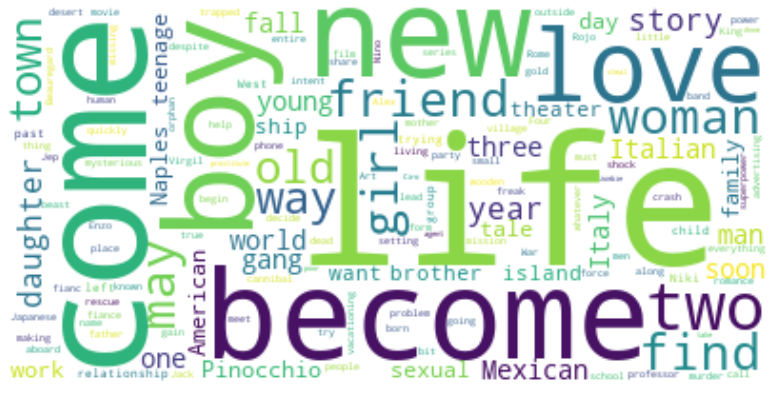

In [41]:
str_it=' '
it_top50=data[data['original_language']=='italian'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in it_top50['corpus']:
    str_it+=i+' '


build_wordcloud(str_it)

In [42]:
build_ldaviz('italian',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.105421 -0.010527       1        1  32.207829
1     -0.064253 -0.096045       2        1  26.964894
0     -0.060864  0.088884       3        1  26.876408
3      0.019695  0.017688       4        1  13.950869, topic_info=        Term      Freq     Total Category  logprob  loglift
10       boy  4.000000  4.000000  Default  30.0000  30.0000
330      may  3.000000  3.000000  Default  29.0000  29.0000
63      town  3.000000  3.000000  Default  28.0000  28.0000
398     want  1.000000  1.000000  Default  27.0000  27.0000
30       old  2.000000  2.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
549  trapped  0.535093  1.571239   Topic4  -5.6578   0.8924
216  theater  0.535089  2.227396   Topic4  -5.6578   0.5435
192   Naples  0.535074  2.191212   Topic4  -5.6579   0.5598
55   becomes  0.535045  2.813222   Topic4  -5.6579   0.3099
387      She  0.535019  2.157038   Topic4  -5.6580   0.5754

[230 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
466       4  1.016564  150-man
313       1  0.555669     1900
418       2  0.874542  20-year
344       1  0.340281    After
344       2  0.340281    After
...     ...       ...      ...
455       3  0.344284     year
161       1  0.381979    young
161       3  0.381979    young
161       4  0.381979    young
804       3  0.578901   zombie

[274 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

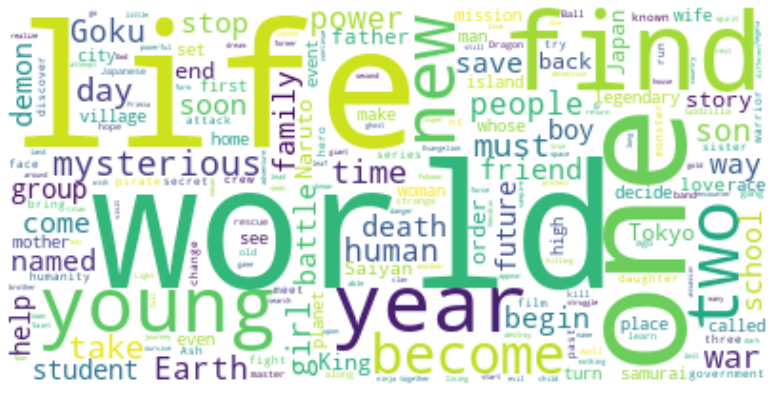

In [43]:
str_ja=' '
for i in data[data['original_language']=='japanese']['corpus']:
    str_ja+=i+' '


build_wordcloud(str_ja)

In [44]:
build_ldaviz('japanese',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.094632  0.068234       1        1  34.822043
1     -0.021848 -0.113388       2        1  27.554440
3      0.109822  0.035663       3        1  26.660985
2      0.006658  0.009491       4        1  10.962531, topic_info=        Term       Freq      Total Category  logprob  loglift
287     Goku  14.000000  14.000000  Default  30.0000  30.0000
182   Naruto  10.000000  10.000000  Default  29.0000  29.0000
508   Minato   3.000000   3.000000  Default  28.0000  28.0000
293   Vegeta   3.000000   3.000000  Default  27.0000  27.0000
230     fire   2.000000   2.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
308  appears   0.536573   2.377652   Topic4  -5.9672   0.7220
18    friend   0.536527   4.309100   Topic4  -5.9673   0.1273
31   student   0.536508   3.667014   Topic4  -5.9674   0.2886
459     love   0.536436   2.321889   Topic4  -5.9675   0.7455
543     fall   0.536368   1.679902   Topic4  -5.9676   1.0690

[234 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
381       2  0.526688    're
213       1  0.883401    ...
1083      2  0.526688    100
124       1  0.439451  After
124       2  0.146484  After
...     ...       ...    ...
284       2  0.412688   year
284       3  0.137563   year
123       1  0.309243  young
123       2  0.309243  young
123       4  0.309243  young

[303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

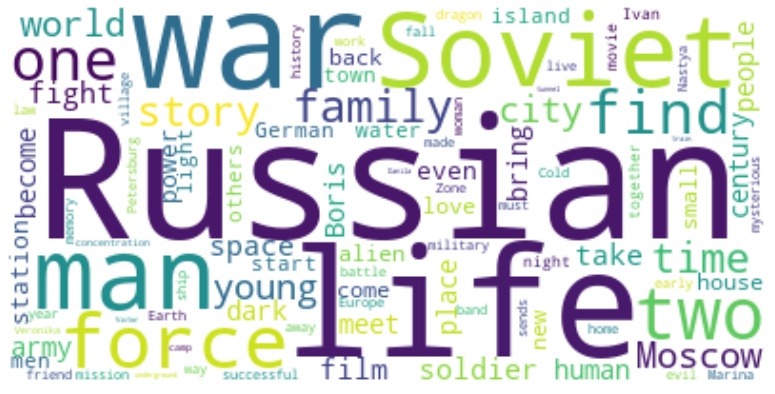

In [45]:
str_ru=' '
for i in data[data['original_language']=='russian']['corpus']:
    str_ru+=i+' '


build_wordcloud(str_ru)

In [46]:
build_ldaviz('russian',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.099580  0.046107       1        1  44.548354
0     -0.097629  0.052340       2        1  23.954431
1     -0.004944 -0.102455       3        1  19.294924
2      0.002993  0.004008       4        1  12.202291, topic_info=        Term      Freq     Total Category  logprob  loglift
135   Soviet  6.000000  6.000000  Default  30.0000  30.0000
635    Boris  3.000000  3.000000  Default  29.0000  29.0000
111    force  5.000000  5.000000  Default  28.0000  28.0000
887   Danila  1.000000  1.000000  Default  27.0000  27.0000
889   Victor  1.000000  1.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
768    three  0.523408  1.693422   Topic4  -5.8450   0.9294
280   German  0.523396  2.937641   Topic4  -5.8450   0.3785
327   behind  0.523375  1.693445   Topic4  -5.8451   0.9293
898       go  0.523373  1.693448   Topic4  -5.8451   0.9293
900  instead  0.523373  1.693448   Topic4  -5.8451   0.9293

[237 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
322       1  0.608872    ...
322       2  0.304436    ...
706       3  0.616441   1943
743       1  1.005584   1965
132       1  0.543034  After
...     ...       ...    ...
98        2  0.439552   year
98        4  0.439552   year
131       1  0.401692  young
131       2  0.401692  young
131       3  0.200846  young

[289 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

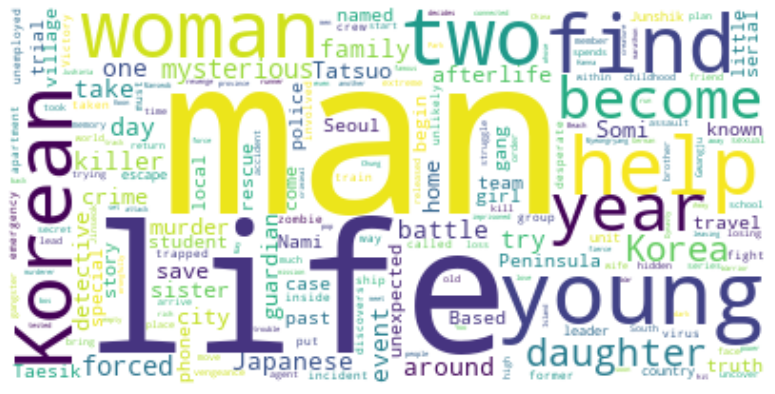

In [47]:
str_ko=' '
ko_top50=data[data['original_language']=='korean'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in ko_top50['corpus']:
    str_ko+=i+' '


build_wordcloud(str_ko)

In [48]:
build_ldaviz('korean',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.115161  0.034957       1        1  30.084734
1     -0.018686 -0.108836       2        1  29.302276
0     -0.085875  0.070093       3        1  25.908949
3     -0.010600  0.003787       4        1  14.704041, topic_info=          Term      Freq     Total Category  logprob  loglift
226       Somi  2.000000  2.000000  Default  30.0000  30.0000
69        find  5.000000  5.000000  Default  29.0000  29.0000
124     around  3.000000  3.000000  Default  28.0000  28.0000
721     Tatsuo  3.000000  3.000000  Default  27.0000  27.0000
590     become  3.000000  3.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
148       move  0.583237  1.675332   Topic4  -5.6714   0.8619
65        city  0.583166  2.935913   Topic4  -5.6715   0.3007
286      South  0.583150  1.675363   Topic4  -5.6715   0.8617
285      Seoul  0.583051  2.276798   Topic4  -5.6717   0.5548
67   desperate  0.583014  1.675408   Topic4  -5.6718   0.8614

[225 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
223       3  0.844968    'the
224       3  0.444210     ...
224       4  0.444210     ...
283       4  0.953924    1997
398       1  0.241623   After
...     ...       ...     ...
222       1  0.314295   young
222       2  0.314295   young
222       3  0.157147   young
222       4  0.314295   young
39        2  0.544512  zombie

[271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

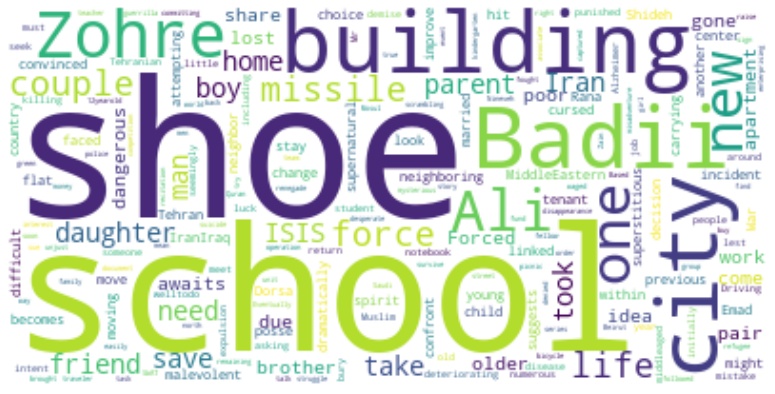

In [49]:
str_pe=' '
for i in data[data['original_language']=='persian']['corpus']:
    str_pe+=i+' '
    
str_ar=' '
for i in data[data['original_language']=='arabic']['corpus']:
    str_ar+=i+' '

str_middleeast=str_pe+str_ar

build_wordcloud(str_middleeast)

In [50]:
build_ldaviz('persian',50)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
3     -0.105771  0.0       1        1  71.143913
0      0.113581  0.0       2        1  26.804256
2     -0.003905  0.0       3        1   1.025916
1     -0.003905  0.0       4        1   1.025914, topic_info=          Term      Freq     Total Category  logprob  loglift
96       Badii  1.000000  1.000000  Default  30.0000  30.0000
15        shoe  2.000000  2.000000  Default  29.0000  29.0000
21    building  2.000000  2.000000  Default  28.0000  28.0000
117        man  1.000000  1.000000  Default  27.0000  27.0000
85      friend  1.000000  1.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
67   Alzheimer  0.011455  1.086524   Topic4  -4.9835   0.0272
69     another  0.011455  1.086524   Topic4  -4.9835   0.0272
70       child  0.011455  1.086524   Topic4  -4.9835   0.0272
71     country  0.011455  1.086524   Topic4  -4.9835   0.0272
72    decision  0.011455  1.086524   Topic4  -4.9835   0.0272

[216 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
39        1  0.920328      After
0         1  1.094317        Ali
67        1  0.920366  Alzheimer
96        2  1.002903      Badii
40        1  0.920328      Dorsa
...     ...       ...        ...
144       1  0.920409    teacher
94        1  0.920390       took
145       1  0.920409   traveler
66        1  0.920328     within
95        1  0.920390       year

[97 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [51]:
build_ldaviz('arabic',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.128706 -0.006581       1        1  45.215884
2      0.073314 -0.092818       2        1  27.597148
0      0.059367  0.100295       3        1  26.130525
3     -0.003975 -0.000897       4        1   1.056443, topic_info=            Term      Freq     Total Category  logprob  loglift
24          city  1.000000  1.000000  Default  30.0000  30.0000
19          ISIS  1.000000  1.000000  Default  29.0000  29.0000
31          home  1.000000  1.000000  Default  28.0000  28.0000
11         right  0.000000  0.000000  Default  27.0000  27.0000
1         Beirut  0.000000  0.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
47         Saudi  0.011052  0.968894   Topic4  -4.1744   0.0767
49           buy  0.011052  0.968894   Topic4  -4.1744   0.0767
52  enterprising  0.011052  0.968894   Topic4  -4.1744   0.0767
54          girl  0.011052  0.968894   Topic4  -4.1744   0.0767
55         green  0.011052  0.968894   Topic4  -4.1744   0.0767

[155 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         3  1.046770  12-year-old
18        1  0.919751        Based
1         3  1.046770       Beirut
19        1  0.575375         ISIS
20        1  0.919751        Mosul
...     ...       ...          ...
44        1  0.919751         unit
16        3  1.046770       unjust
45        1  0.919751        waged
64        2  1.032104          way
17        3  1.046770        world

[65 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

# Building the recommendation system : Content Based

In [61]:
stored_movie_alllang=[str_hi,str_en,str_es,str_fr,str_it,str_ko,str_ja,str_ru,str_pe,str_ar]

In [22]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-distilroberta-v1')


In [27]:
encodings=model.encode(data['corpus2'])

In [187]:
encodings

array([[-2.15467829e-02, -5.19864187e-02, -3.17499787e-02, ...,
         5.68524556e-05, -1.44541292e-02,  1.90606900e-02],
       [-3.40640321e-02, -1.32841086e-02, -2.40801312e-02, ...,
         2.64237425e-03,  3.03323809e-02,  4.26904969e-02],
       [-1.51118645e-02,  5.34065359e-04, -1.76539980e-02, ...,
         6.33948296e-02, -4.49554510e-02,  1.25087693e-03],
       ...,
       [ 1.83257740e-02, -5.21918684e-02, -2.25877725e-02, ...,
        -7.66326394e-03,  3.28837968e-02, -1.86262615e-02],
       [ 7.24272989e-03, -8.05756152e-02, -3.23694162e-02, ...,
         5.86061133e-03, -1.61450468e-02, -3.54598314e-02],
       [ 1.41059121e-04,  1.18350545e-02,  2.53772903e-02, ...,
        -7.29825813e-03, -1.13201877e-02,  3.02658640e-02]], dtype=float32)

In [66]:
def make_recommendations(query_index):
    
    def initiate_model_and_predict(encodings, query_index):
        
        from sklearn.neighbors import NearestNeighbors
        model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    
        model_knn.fit(encodings)
    
        distances, indices = model_knn.kneighbors([encodings[query_index,:]], n_neighbors = 50)
    
        movie_id=data['id'][query_index]
    
        movie_ids_stored=[]
    
        for i in range(0, len(distances.flatten())):
            movie_ids_stored.append(data.id[indices.flatten()[i]])
        
        return movie_ids_stored, movie_id
    
    movie_ids_stored,user_movie_ids=initiate_model_and_predict(encodings, query_index)
    
    def select_sort_recommendations(movie_ids_stored,user_movie_ids):
        
        movie_popularity=[]
        movie_vote_average=[]
        movie_language=[]
        movie_name=[]
        movie_overview=[]
        movie_ids_recc=[]
    
        for movie_ids in movie_ids_stored:
            movie_ids_recc.append(movie_ids)
            movie_name.append(data[data['id']==movie_ids]['title'].values[0])
            movie_popularity.append(data[data['id']==movie_ids]['popularity'].values[0])
            movie_vote_average.append(data[data['id']==movie_ids]['vote_average'].values[0])
            movie_language.append(data[data['id']==movie_ids]['original_language'].values[0])
            movie_overview.append(data[data['id']==movie_ids]['overview'].values[0])
        
        
        recommended_movies_df=pd.DataFrame(list(zip(movie_ids_recc,movie_name,movie_popularity,movie_vote_average,movie_overview,movie_language))
                                      ,columns=['Id','Name','Popularity','Avg_votes','Overview','Language'])
    
    
    
    
        top2=recommended_movies_df.head(4)
        user_movie_language=data[data['id']==user_movie_ids]['original_language'].values[0]
    
        top_recommend=recommended_movies_df[recommended_movies_df['Language']==user_movie_language]
    #return top_recommend
    
        if len(top_recommend)==0:
            try:
                top_recommend=recommended_movies_df[recommended_movies_df['Language']=='english']
                top_recommend.reset_index(drop=True,inplace=True)
                print(top_recommend)
                top_recommend.sort_values(by=['Avg_votes','Popularity'],ascending=False,inplace=True)
                top1_popular=top_recommend.head(2)
                final_recommend=pd.concat([top1_popular,top2,top_recommend,recommended_movies_df])
                final_recommend.drop_duplicates(subset=['Name'],keep='first',inplace=True)
            except:
                pass
        
        #final_recommend=pd.concat([top_recommend,recommended_movies_df])
        #final_recommend.drop_duplicates(subset=['Name'],keep='first',inplace=True)
        
        else:
            top_recommend.reset_index(drop=True,inplace=True)
            #print(top_recommend)
            top_recommend.sort_values(by=['Avg_votes','Popularity'],ascending=False,inplace=True)
            #print(top_recommend_1)
            top1_popular=top_recommend.head(2)
            #print(top1_popular)
        
            try:
                top_recommend_2=recommended_movies_df[recommended_movies_df['Language']=='english']
                top_recommend_2.reset_index(drop=True,inplace=True)
                top_recommend_2.sort_values(by=['Avg_votes','Popularity'],ascending=False,inplace=True)
                final_recommend=pd.concat([top1_popular,top2,top_recommend,top_recommend_2,recommended_movies_df])
                final_recommend.drop_duplicates(subset=['Name'],keep='first',inplace=True)
            except:
                top_recommend_2=top_recommend
                final_recommend=pd.concat([top1_popular,top2,top_recommend,top_recommend_2,recommended_movies_df])
                final_recommend.drop_duplicates(subset=['Name'],keep='first',inplace=True)
        
        #final_recommend=pd.concat([top_recommend_1,top_recommend_2,recommended_movies_df])
        #final_recommend.drop_duplicates(subset=['Name'],keep='first',inplace=True)
        final_recommend.reset_index(drop=True,inplace=True)   
        recommended_ids=[final_recommend['Id'][i] for i in range(len(final_recommend))]
        return recommended_ids
 
    ids=select_sort_recommendations(movie_ids_stored,user_movie_ids)
    
    if user_movie_ids in ids:
        ids.remove(user_movie_ids)
    return ids
    
    
        
    
    
    
    
    

In [34]:
data['id'][569]

458305

In [40]:
data[data['id']==18240]

Unnamed: 0     id  adult         title original_language  \
453        2919  18240  False  The Proposal           english   

                                              overview       title.1  \
453  When she learns she's in danger of losing her ...  The Proposal   

     popularity release_date  vote_average  vote_count timeframes  \
453     115.432   2009-06-01           7.1        5591  2000-2010   

                                                corpus  \
453  learns danger losing visa status deported over...   

                                               corpus2  
453  [learns, danger, losing, visa, status, deporte...

In [58]:
make_recommendations(569)

        Id                Name  Popularity  Avg_votes  \
34  576845  Last Night in Soho     128.085        7.5   

                                             Overview Language  
34  A young girl, passionate about fashion design,...  english  


[576845,
 352490,
 520172,
 401104,
 582014,
 387426,
 112949,
 318781,
 317557,
 336000,
 18093,
 11013,
 244506,
 29161,
 471506,
 529862,
 400157,
 7442,
 293970,
 44754,
 14976,
 10307,
 23629,
 864873,
 301334,
 487083,
 77883,
 244610,
 492611,
 347754,
 4641,
 310137,
 10281,
 1975,
 362826,
 14913,
 76617,
 203834,
 19794,
 204349,
 359790,
 13788,
 283726,
 9539,
 21484,
 19204,
 5139,
 437109,
 129]

In [68]:
recommendations=[]

for i in range(len(data)):
    array=make_recommendations(i)
    #print(array)
    recommendations.append(array)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341


6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980


8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620


In [69]:
data['recommendaions']=recommendations

In [73]:
data

Unnamed: 0      id  adult                     title original_language  \
0            174  766507  False                      Prey           english   
1           4270  616037  False    Thor: Love and Thunder           english   
2           2860  507086  False   Jurassic World Dominion           english   
3            593  438148  False  Minions: The Rise of Gru           english   
4             65  361743  False         Top Gun: Maverick           english   
...          ...     ...    ...                       ...               ...   
9964        3680  203819  False                    Tracks           english   
9965          30   12477  False    Grave of the Fireflies          japanese   
9966        5429  203793  False                Stalingrad           russian   
9967          37   92321  False        Hotarubi no Mori e          japanese   
9968        3762   11367  False            Odds and Evens           italian   

                                               overview  \
0     When danger threatens her camp, the fierce and...   
1     After his retirement is interrupted by Gorr th...   
2     Four years after Isla Nublar was destroyed, di...   
3     A fanboy of a supervillain supergroup known as...   
4     After more than thirty years of service as one...   
...                                                 ...   
9964  Accompanied only by her faithful dog and four ...   
9965  In the final months of World War II, 14-year-o...   
9966  A band of determined Russian soldiers fight to...   
9967  One hot summer day a little girl gets lost in ...   
9968  A bumbling government agent recruits a trucker...   

                       title.1  popularity release_date  vote_average  \
0                         Prey   16755.428   2022-08-02           8.2   
1       Thor: Love and Thunder    9383.627   2022-07-06           6.8   
2      Jurassic World Dominion    6152.098   2022-06-01           7.1   
3     Minions: The Rise of Gru    5616.926   2022-06-29           7.8   
4            Top Gun: Maverick    5133.389   2022-05-24           8.3   
...                        ...         ...          ...           ...   
9964                    Tracks       0.600   2013-12-19           6.9   
9965    Grave of the Fireflies       0.600   1988-04-16           8.4   
9966                Stalingrad       0.600   2013-10-09           6.5   
9967        Hotarubi no Mori e       0.600   2011-09-17           8.4   
9968            Odds and Evens       0.600   1978-10-28           6.9   

      vote_count timeframes  \
0           2280  2010-2022   
1           1838  2010-2022   
2           2753  2010-2022   
3           1331  2010-2022   
4           1892  2010-2022   
...          ...        ...   
9964         426  2010-2022   
9965        4242  1985-2000   
9966         283  2010-2022   
9967         820  2010-2022   
9968         321  1945-1985   

                                                 corpus  \
0     danger threatens camp fierce highly skilled Co...   
1     After retirement interrupted Gorr God Butcher ...   
2     Four year Isla Nublar destroyed dinosaur livea...   
3     fanboy supervillain supergroup known Vicious G...   
4     After thirty year service one Navy top aviator...   
...                                                 ...   
9964  Accompanied faithful dog four camel Australian...   
9965  final month World War 14yearold Seita sister S...   
9966  band determined Russian soldier fight hold str...   
9967  One hot summer day little girl get lost enchan...   
9968  bumbling government agent recruit trucker whos...   

                                                corpus2  \
0     [danger, threatens, camp, fierce, highly, skil...   
1     [After, retirement, interrupted, Gorr, God, Bu...   
2     [Four, year, Isla, Nublar, destroyed, dinosaur...   
3     [fanboy, supervillain, supergroup, known, Vici...   
4     [After, thirty, year, service, one, Navy, top,...   
...                                

In [74]:
data_with_recommendations=data.drop(['corpus2'],axis=1)

In [81]:
data_with_recommendations.to_csv('Recommendations_data.csv')

In [82]:
make_recommends=pd.read_csv(r'Recommendations_data.csv')

In [83]:
make_recommends

Unnamed: 0.1  Unnamed: 0      id  adult                     title  \
0                0         174  766507  False                      Prey   
1                1        4270  616037  False    Thor: Love and Thunder   
2                2        2860  507086  False   Jurassic World Dominion   
3                3         593  438148  False  Minions: The Rise of Gru   
4                4          65  361743  False         Top Gun: Maverick   
...            ...         ...     ...    ...                       ...   
9964          9964        3680  203819  False                    Tracks   
9965          9965          30   12477  False    Grave of the Fireflies   
9966          9966        5429  203793  False                Stalingrad   
9967          9967          37   92321  False        Hotarubi no Mori e   
9968          9968        3762   11367  False            Odds and Evens   

     original_language                                           overview  \
0              english  When danger threatens her camp, the fierce and...   
1              english  After his retirement is interrupted by Gorr th...   
2              english  Four years after Isla Nublar was destroyed, di...   
3              english  A fanboy of a supervillain supergroup known as...   
4              english  After more than thirty years of service as one...   
...                ...                                                ...   
9964           english  Accompanied only by her faithful dog and four ...   
9965          japanese  In the final months of World War II, 14-year-o...   
9966           russian  A band of determined Russian soldiers fight to...   
9967          japanese  One hot summer day a little girl gets lost in ...   
9968           italian  A bumbling government agent recruits a trucker...   

                       title.1  popularity release_date  vote_average  \
0                         Prey   16755.428   2022-08-02           8.2   
1       Thor: Love and Thunder    9383.627   2022-07-06           6.8   
2      Jurassic World Dominion    6152.098   2022-06-01           7.1   
3     Minions: The Rise of Gru    5616.926   2022-06-29           7.8   
4            Top Gun: Maverick    5133.389   2022-05-24           8.3   
...                        ...         ...          ...           ...   
9964                    Tracks       0.600   2013-12-19           6.9   
9965    Grave of the Fireflies       0.600   1988-04-16           8.4   
9966                Stalingrad       0.600   2013-10-09           6.5   
9967        Hotarubi no Mori e       0.600   2011-09-17           8.4   
9968            Odds and Evens       0.600   1978-10-28           6.9   

      vote_count timeframes  \
0           2280  2010-2022   
1           1838  2010-2022   
2           2753  2010-2022   
3           1331  2010-2022   
4           1892  2010-2022   
...          ...        ...   
9964         426  2010-2022   
9965        4242  1985-2000   
9966         283  2010-2022   
9967         820  2010-2022   
9968         321  1945-1985   

                                                 corpus  \
0     danger threatens camp fierce highly skilled Co...   
1     After retirement interrupted Gorr God Butcher ...   
2     Four year Isla Nublar destroyed dinosaur livea...   
3     fanboy supervillain supergroup known Vicious G...   
4     After thirty year service one Navy top aviator...   
...                                                 ...   
9964  Accompanied faithful dog four camel Australian...   
9965  final month World War 14yearold Seita sister S...   
9966  band determined Russian soldier fight hold str...   
9967  One hot summer day little girl get lost enchan...   
9968  bumbling government agent recruit trucker whos...   

                                         recommendaions  
0     [476968, 18240, 427348, 560144, 31682, 5548, 1...  
1     [458220, 5915, 284052, 8998, 209249, 707886, 7...  
2     [537061, 673, 330, 1826, 7942, 80, 82702,

In [380]:
int(make_recommends['recommendaions'][1].split(',')[1])

5915

In [437]:
data['recommendaions']

0       [18240, 427348, 560144, 476968, 31682, 5548, 1...
1       [284052, 8998, 209249, 458220, 5915, 707886, 7...
2       [330, 1826, 7942, 537061, 673, 80, 82702, 1323...
3       [615678, 308531, 38055, 10242, 841755, 431693,...
4       [41664, 82696, 787, 664767, 359940, 9377, 2637...
                              ...                        
9964    [464502, 41411, 9003, 264644, 272, 2493, 3309,...
9965    [1487, 228150, 586, 761053, 406997, 10681, 110...
9966    [330459, 14846, 12775, 157336, 791373, 550205,...
9967    [13930, 41665, 79, 9495, 492, 14638, 13933, 57...
9968    [37137, 11302, 9101, 975, 500, 282848, 489412,...
Name: recommendaions, Length: 9969, dtype: object

In [84]:
def clean_recs(x):
    import re
    x=re.sub('[^0-9, ]','',x)
    
    return x

In [85]:
make_recommends['recommendaions']=make_recommends['recommendaions'].apply(lambda x: clean_recs(x))

In [86]:
def normalize_names(title):
    
    import re
    title=title.lower()
    title=re.sub('[^a-z0-9 ]','',title)
    
    return title

make_recommends['normalized_names']=make_recommends['title'].apply(lambda x: normalize_names(x))



In [87]:
make_recommends.to_csv('Recommendations_data.csv')

In [382]:
normalized_names_to_match=[make_recommends['normalized_names'][i] for i in range(len(make_recommends))]

In [117]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

In [289]:
model_knn.fit(encodings)

NearestNeighbors(algorithm='brute', metric='cosine')

In [290]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(model_knn, open(filename, 'wb'))

In [291]:
loaded_model = pickle.load(open(filename, 'rb'))

In [269]:
data.drop(['bert_encodings_plot'],axis=1,inplace=True)

In [272]:
data.to_csv('Movie_recommended_encoding.csv')

In [301]:
query_index = np.random.choice(data.shape[0])
print(query_index)
distances, indices = loaded_model.kneighbors([encodings[1,:]], n_neighbors = 50)

1841


In [162]:
movie_ids_stored=[]
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(data['id'][query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, data.id[indices.flatten()[i]], distances.flatten()[i]))
        movie_ids_stored.append(data.id[indices.flatten()[i]])

Recommendations for 423108:

1: 284052, with distance of 0.21172165870666504:
2: 8998, with distance of 0.2154834270477295:
3: 209249, with distance of 0.2249155044555664:
4: 1931, with distance of 0.22955167293548584:
5: 26263, with distance of 0.22955167293548584:
6: 1689, with distance of 0.22955167293548584:
7: 291272, with distance of 0.22955167293548584:
8: 12618, with distance of 0.22955167293548584:
9: 9816, with distance of 0.22955167293548584:
10: 7341, with distance of 0.2593587636947632:
11: 244268, with distance of 0.26099979877471924:
12: 435, with distance of 0.26099979877471924:
13: 288281, with distance of 0.26099979877471924:
14: 2770, with distance of 0.26099979877471924:
15: 823461, with distance of 0.26099979877471924:
16: 458220, with distance of 0.26099979877471924:
17: 180863, with distance of 0.26099979877471924:
18: 2925, with distance of 0.26099979877471924:
19: 41283, with distance of 0.26099979877471924:
20: 2789, with distance of 0.26099979877471924:
21: 3

In [163]:
movie_ids_stored

[284052,
 8998,
 209249,
 1931,
 26263,
 1689,
 291272,
 12618,
 9816,
 7341,
 244268,
 435,
 288281,
 2770,
 823461,
 458220,
 180863,
 2925,
 41283,
 2789,
 38358,
 6217,
 174,
 10576,
 47796,
 595867,
 10218,
 246655,
 145247,
 310569,
 89691,
 9072,
 11821,
 1535,
 9538,
 407451,
 5915,
 1567,
 654974,
 1273,
 10665,
 2291,
 780382,
 87,
 398175,
 11281,
 169209,
 707886,
 291276]

In [79]:
data[data['title']=='Doctor Strange']['popularity']

286     154.971
3456     20.358
Name: popularity, dtype: float64

In [130]:
data[data['id']==291276]['popularity'].values[0]

16.214

In [302]:
data

Unnamed: 0.1  Unnamed: 0      id  adult                     title  \
0                0         174  766507  False                      Prey   
1                1        4270  616037  False    Thor: Love and Thunder   
2                2        2860  507086  False   Jurassic World Dominion   
3                3         593  438148  False  Minions: The Rise of Gru   
4                4          65  361743  False         Top Gun: Maverick   
...            ...         ...     ...    ...                       ...   
9964          9964        3680  203819  False                    Tracks   
9965          9965          30   12477  False    Grave of the Fireflies   
9966          9966        5429  203793  False                Stalingrad   
9967          9967          37   92321  False        Hotarubi no Mori e   
9968          9968        3762   11367  False            Odds and Evens   

     original_language                                           overview  \
0              english  When danger threatens her camp, the fierce and...   
1              english  After his retirement is interrupted by Gorr th...   
2              english  Four years after Isla Nublar was destroyed, di...   
3              english  A fanboy of a supervillain supergroup known as...   
4              english  After more than thirty years of service as one...   
...                ...                                                ...   
9964           english  Accompanied only by her faithful dog and four ...   
9965          japanese  In the final months of World War II, 14-year-o...   
9966           russian  A band of determined Russian soldiers fight to...   
9967          japanese  One hot summer day a little girl gets lost in ...   
9968           italian  A bumbling government agent recruits a trucker...   

                       title.1  popularity release_date  vote_average  \
0                         Prey   16755.428   2022-08-02           8.2   
1       Thor: Love and Thunder    9383.627   2022-07-06           6.8   
2      Jurassic World Dominion    6152.098   2022-06-01           7.1   
3     Minions: The Rise of Gru    5616.926   2022-06-29           7.8   
4            Top Gun: Maverick    5133.389   2022-05-24           8.3   
...                        ...         ...          ...           ...   
9964                    Tracks       0.600   2013-12-19           6.9   
9965    Grave of the Fireflies       0.600   1988-04-16           8.4   
9966                Stalingrad       0.600   2013-10-09           6.5   
9967        Hotarubi no Mori e       0.600   2011-09-17           8.4   
9968            Odds and Evens       0.600   1978-10-28           6.9   

      vote_count timeframes  \
0           2280  2010-2022   
1           1838  2010-2022   
2           2753  2010-2022   
3           1331  2010-2022   
4           1892  2010-2022   
...          ...        ...   
9964         426  2010-2022   
9965        4242  1985-2000   
9966         283  2010-2022   
9967         820  2010-2022   
9968         321  1945-1985   

                                                 corpus  \
0     danger threatens camp fierce highly skilled Co...   
1     After retirement interrupted Gorr God Butcher ...   
2     Four year Isla Nublar destroyed dinosaur livea...   
3     fanboy supervillain supergroup known Vicious G...   
4     After thirty year service one Navy top aviator...   
...                                                 ...   
9964  Accompanied faithful dog four camel Australian...   
9965  final month World War 14yearold Seita sister S...   
9966  band determined Russian soldier fight hold str...   
9967  One hot summer day little girl get lost enchan...   
9968  bumbling government agent recruit trucker whos...   

                                                corpus2  \
0     ['danger', 'threatens', 'camp', 'fierce', 'hig...   
1     ['After', 'retirement', 'interrupted', 'Gorr',...   
2     ['Four', 'year', 'Isla', 'Nublar', 'de

# Comparison between movie plots

In [63]:
emb_hi=model.encode(str_hi)
emb_en=model.encode(str_en)
emb_es=model.encode(str_es)
emb_fr=model.encode(str_fr)
emb_it=model.encode(str_it)
emb_ko=model.encode(str_ko)
emb_ja=model.encode(str_ja)
emb_ru=model.encode(str_ru)
emb_pe=model.encode(str_pe)
emb_ar=model.encode(str_ar)



embeddings=[emb_hi,emb_en,emb_es,emb_fr,emb_it,emb_ko,emb_ja,emb_ru,emb_pe,emb_ar]

In [64]:
from sklearn.metrics.pairwise import cosine_similarity as cs

In [65]:
cs([emb_hi],[emb_en])

array([[0.6390718]], dtype=float32)

In [66]:
scores=[]
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        s=cs([embeddings[i]],[embeddings[j]])
        scores.append(s)

In [67]:
len(scores)

100

In [68]:
scores_arr=np.array(scores).reshape(-10,10)
scores_arr

array([[1.        , 0.6390718 , 0.7815536 , 0.82303417, 0.80340624,
        0.80153763, 0.6578844 , 0.6464155 , 0.6094659 , 0.19634387],
       [0.6390718 , 1.0000002 , 0.6807716 , 0.74994636, 0.75749683,
        0.8053731 , 0.74957883, 0.71122456, 0.43648782, 0.13812205],
       [0.7815536 , 0.6807716 , 1.0000002 , 0.86842334, 0.8773853 ,
        0.772079  , 0.65887046, 0.60411245, 0.53441   , 0.16101721],
       [0.82303417, 0.74994636, 0.86842334, 0.9999999 , 0.88822556,
        0.8518838 , 0.6546128 , 0.73595035, 0.5809854 , 0.20567106],
       [0.80340624, 0.75749683, 0.8773853 , 0.88822556, 1.        ,
        0.83054703, 0.69308513, 0.7046212 , 0.49118847, 0.07243682],
       [0.80153763, 0.8053731 , 0.772079  , 0.8518838 , 0.83054703,
        1.        , 0.7365475 , 0.72521824, 0.58530736, 0.13857666],
       [0.6578844 , 0.74957883, 0.65887046, 0.6546128 , 0.69308513,
        0.7365475 , 0.9999999 , 0.7003844 , 0.47201598, 0.14081614],
       [0.6464155 , 0.71122456, 0.6041124

In [69]:
mean_similarity_arr=[]
for i in range(len(scores_arr)):
    mean_similarity=1-np.mean(scores_arr[i])
    mean_similarity_arr.append(mean_similarity)
    

In [70]:
mean_similarity_arr

[0.3041287064552307,
 0.33319270610809326,
 0.30613768100738525,
 0.264126718044281,
 0.28816068172454834,
 0.2752929925918579,
 0.35362040996551514,
 0.35844194889068604,
 0.44061946868896484,
 0.7368881106376648]

In [71]:
ylab=['hindi','english','spanish','french','italian','korean','japanese','russian','persian','arabic']
xlab=ylab

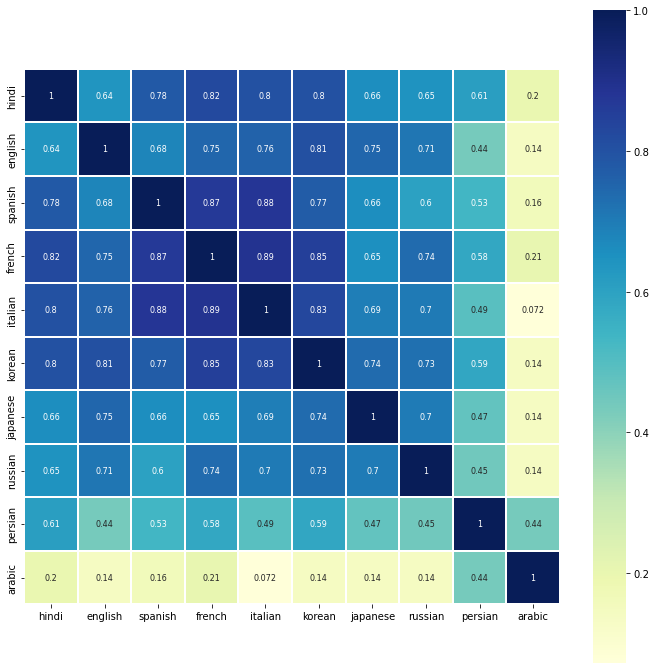

<Figure size 432x288 with 0 Axes>

In [124]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(scores_arr, xticklabels=xlab,yticklabels=ylab,square=True, cmap="YlGnBu", linewidths=0.1,annot=True, annot_kws={"fontsize":8})
plt.show()
plt.savefig('similarity.png')

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()
docs = tfidf.fit_transform(data['corpus'])

In [127]:
from sklearn.decomposition import PCA
pca=PCA(2)
x_pca=pca.fit_transform(docs.toarray())

In [82]:
x_pca

array([[-0.10328283, -0.10791889],
       [-0.1062711 , -0.11967775],
       [-0.10560261, -0.11681701],
       ...,
       [-0.10193802, -0.11007925],
       [-0.10906109, -0.12056187],
       [-0.09289064, -0.10019957]])

9969

In [130]:
import plotly.express as px

fig = px.scatter(x_pca, x=x_pca[:,0], y=x_pca[:,1],color=data['timeframes'],
                 hover_name=data['title'],title='Visualization of top movies across the world, across different timeframes',log_x=False, size_max=100)
fig.show()



In [100]:
import chart_studio

username='odetothecode'
api_key='g9qGi5QONnwvqoeXH8hg'

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

import chart_studio.plotly as py
import chart_studio.tools as tls

In [110]:
x_pca[0]

array([-0.05805572, -0.00647145])

In [111]:
data['pca_coords']=list(x_pca)

In [131]:
data_hi=data[data['original_language']=='hindi']
data_hi.reset_index(drop=True,inplace=True)

tfidf=TfidfVectorizer()
docs = tfidf.fit_transform(data_hi['corpus'])

from sklearn.decomposition import PCA
pca=PCA(2)
x_pca=pca.fit_transform(docs.toarray())

In [133]:
fig = px.scatter(x_pca, x=x_pca[:,0], y=x_pca[:,1],color=data_hi['timeframes'], title='Visualization of top movies across India, across different timeframes'
                 ,hover_name=data_hi['title'], log_x=False, size_max=100)
fig.show()

In [122]:
py.plot(fig,'Movies_across_timeframes',auto_open=False)

'https://plotly.com/~odetothecode/2/'